In [7]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.tseries.offsets import MonthEnd
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder
from sklearn.model_selection import cross_val_score
from keras.models import Sequential, load_model
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.layers import LSTM,Dropout, Dense
from keras.optimizers import SGD, Adam
from keras.preprocessing.sequence import TimeseriesGenerator
import ta
import datetime as dt
import tensorflow as tf
import psycopg2
from pandas.tseries.holiday import USFederalHolidayCalendar
import requests
from dateutil.relativedelta import relativedelta, FR
import json

### Extra Functions

In [8]:
def tiingo_api(user_key,tickers,b_date,e_date,freq='Daily'):
    from tiingo import TiingoClient
    config = {}
    config['session'] = True
    config['api_key'] = user_key
    # Initialize
    client = TiingoClient(config)

    if isinstance(tickers, list):
        data_store = {}
        for ticker in tickers:
            data = pd.DataFrame(client.get_ticker_price(ticker,fmt='json',
                                            startDate=b_date,endDate=e_date,
                                            frequency=freq))
            index = data['date'].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
            data_store[ticker] = data

        panel_data = pd.concat(data_store).unstack(level=0)
        panel_data = panel_data.set_index(index)
        panel_data.drop(['date','adjOpen','adjLow','adjHigh','adjVolume','divCash','splitFactor'],
                        axis=1,inplace=True)
        cols = {'close':'Close','open':'Open',
               'high':'High','low':'Low',
               'adjClose':'AdjClose','volume':'Volume'}
        panel_data.rename(columns=cols,inplace=True)
        return panel_data
    else:
        data = pd.DataFrame(client.get_ticker_price(tickers,fmt='json',
                                        startDate=b_date,endDate=e_date,
                                        frequency=freq))
        index = data['date'].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))

        data = data.set_index(index)
        data.drop(['date','adjOpen','adjLow','adjHigh','adjVolume','divCash','splitFactor'],
                        axis=1,inplace=True)
        cols = {'close':'Close','open':'Open',
               'high':'High','low':'Low',
               'adjClose':'AdjClose'}
        data.rename(columns=cols,inplace=True)
        return data
    
def basic_accuracy_derivation(data):
    correct = 0 
    incorrect = 0
    for i in range(0,len(data)):

        row_result = data.iloc[i]['Test Direction'] == data.iloc[i]['Pred Direction']

        if row_result:
            correct += 1 
        else:
            incorrect += 1
    total = correct + incorrect
    accuracy = correct/total

    return round(accuracy,3)


tf.autograph.set_verbosity(0)
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

def gather_data_derive_vars(ticker,b_date,e_date):
    data = pdr.DataReader(ticker,'yahoo',b_date,e_date)
    security_high = data['High']
    security_low = data['Low']
    security_close = data['Close']
    rsi_val = ta.momentum.RSIIndicator(security_close,window=2)
    keltner_lower = ta.volatility.keltner_channel_lband(security_high,
                                                        security_low,
                                                        security_close,
                                                        window=21,
                                                        window_atr=2)
    keltner_upper = ta.volatility.keltner_channel_hband(security_high,
                                                        security_low,
                                                        security_close,
                                                        window=21,
                                                        window_atr=2)
    stoch = ta.momentum.StochasticOscillator(security_high,
                                             security_low,
                                             security_close,
                                             window=8,
                                             smooth_window=3)

    data['RSI'] = rsi_val.rsi()
    data['Lower Kelt'] = keltner_lower
    data['Upper Kelt'] = keltner_upper
    data['Fast Stoch'] = stoch.stoch()
    data['Slow Stoch'] = stoch.stoch_signal()
    data.dropna(inplace=True)

    data = data[['Close','High','Low','Open', 
                 'RSI', 'Lower Kelt','Upper Kelt',
                 'Fast Stoch','Slow Stoch']]

    return data


### Update Direction Function
* For use with Keras Model V2

In [3]:
from datetime import datetime
import threading

def update_true_direction():
    local_db_conn = psycopg2.connect('dbname=GOSCC user=postgres')
    cur = local_db_conn.cursor()
    date = dt.datetime.today().date()
    # One Month Data Beginning
    b_date = date - relativedelta(weekday=FR(-4))
    # Gather all ticker values in the database
    cur.execute('SELECT DISTINCT ticker FROM keras_production')
    ticker_list = cur.fetchall()
    len_list = len(ticker_list)
    for i in range(0,len_list):
        ticker_list[i] = ticker_list[i][0]
        
    # Update True Direction for Each Ticker
    for ticker in ticker_list:
        # Gather Stock Data
        data = pdr.DataReader(ticker,'yahoo',b_date,dt.datetime.today().date())
        # Check Closing Values and Assign True Direction
        data['Close Diff'] = data['Close'] - data['Close'].shift(1)
        data.dropna(inplace=True)
        data['True Direction'] = data['Close Diff'].apply(lambda x: 'DOWN' if x < 0 else 'UP')
        
        # Find most Recent Prediction
        cur.execute('SELECT * FROM keras_production WHERE ticker LIKE %s ORDER BY row_id ASC', (ticker,))
        data_pull = cur.fetchall()[-1]
        last_model_date = str(data_pull[1])

        previous_day_true_direction = data[(data.index == last_model_date)]['True Direction'].values[0]

        cur.execute("UPDATE keras_production SET true_direction = %s WHERE pred_date= %s AND ticker = %s",
                (previous_day_true_direction,date,ticker))
        local_db_conn.commit()

# def check_time_run_true_direction_update():
#     # This function runs periodically every 1 second
#     threading.Timer(1, check_time_run_true_direction_update).start()

#     now = datetime.now()

#     current_time = now.strftime("%H:%M:%S")
#     date = dt.datetime.today().weekday()
#     if (date != 5) and (date != 6):
#         if(current_time == '18:00:00'):  # check if matches with the desired time
#             update_true_direction()


# check_time_run_true_direction_update()

In [4]:
update_true_direction()

### Keras Price Modeling
* Two functions to derive accuracy of a model and the model(s) themselves. 
* The Keras Model:
    * A deep neural net which utilizes basic stock data variables (open, low, close, volume, etc.) and technical analysis indicators. The model is tasked with predicting stock price. 
    * After developing an initial model, accuracy is taken. 
    * Next, a simpler model is used to predict one out-of-sample value for each variable. 
    * Finally, the set of predicted values are fed into the first mentioned model to provide a single price prediction. 
    * Overall, this method allows a user to predict price action one day ahead of the current market environment.
    

In [ ]:
### Single Function
tf.autograph.set_verbosity(0)
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

def keras_single_price_prediction(stock_list,b_date,e_date):
    output_dict = {} 
    
    for i in stock_list:
        print('\n')
        print(f'Working on {i} modeling. ')
        print('\n')
        data = pdr.DataReader(i,'yahoo',b_date,e_date)
        security_high = data['High']
        security_low = data['Low']
        security_close = data['Close']
        rsi_val = ta.momentum.RSIIndicator(security_close,window=2)
        keltner_lower = ta.volatility.keltner_channel_lband(security_high,
                                                            security_low,
                                                            security_close,
                                                            window=21,
                                                            window_atr=2)
        
        keltner_upper = ta.volatility.keltner_channel_hband(security_high,
                                                            security_low,
                                                            security_close,
                                                            window=21,
                                                            window_atr=2)

        stoch = ta.momentum.StochasticOscillator(security_high,
                                                 security_low,
                                                 security_close,
                                                 window=8,
                                                 smooth_window=3)


        data['RSI'] = rsi_val.rsi()
        data['Lower Kelt'] = keltner_lower
        data['Upper Kelt'] = keltner_upper
        data['Fast Stoch'] = stoch.stoch()
        data['Slow Stoch'] = stoch.stoch_signal()
        data.dropna(inplace=True)
        data = data[['Close','High','Low','Open',
                     'Volume', 'RSI', 'Lower Kelt','Upper Kelt',
                     'Fast Stoch','Slow Stoch']]
        
        data.dropna(inplace=True)
        
        ## Overall Model ---------------------------------------------------------------------------
        split_date = pd.Timestamp('04-30-2021')
        train_df, test_df = data[:split_date],data.loc[split_date:]
        test_index = test_df.index
        
        ss = MinMaxScaler(feature_range=(-1,1),)
        train_sc = ss.fit_transform(train_df)
        test_sc = ss.transform(test_df)
        
        X_train = train_sc[:,1:]
        y_train = train_sc[:,0]

        X_test = test_sc[:,1:]
        y_test = test_sc[:,0]

        X_train = X_train[:,None]
        X_test = X_test[:,None]

        model_data_df = []
        K.clear_session()
        price_model = Sequential()
        price_model.add(LSTM(25, input_shape=(1,9)))
        price_model.add(Dropout(0.15))
        # model.add(Dense(25,activation="relu"))
        price_model.add(Dense(15,input_shape=(10,10),activation='relu'))
        price_model.add(Dense(5,input_shape=(10,1),activation='relu'))
        price_model.add(Dense(1))
        price_model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.01))

        # early_stop = EarlyStopping(monitor='loss',patience=1,verbose=0)
        price_model.fit(X_train,y_train, epochs=100, batch_size=32,verbose=0)#,callbacks=[early_stop])

        
        y_pred = price_model.predict(X_test)
        
        # Saving Model -----------------------------------------------------------------
        model_path = 'modeling/current_'+i+'_price_model_'+str(dt.datetime.today().date())+'.h5'
        price_model.save(model_path)
        
        pred = pd.DataFrame(y_pred,columns=['Pred'])
        y = pd.DataFrame(y_test,columns=['Test'])

        results = y.join(pred)
        results['Test Diff'] = results['Test'] - results['Test'].shift()
        results['Pred Diff'] = results['Pred'] - results['Pred'].shift()

        results['Test Direction'] = results['Test Diff'].apply(lambda x: 'DOWN' if x < 0 else 'UP')
        results['Pred Direction'] = results['Pred Diff'].apply(lambda x: 'DOWN' if x < 0 else 'UP')

        results['dates'] = test_index
        # Sunday is 6
        # Monday is 0 
        # etc
        results['weekday'] = test_index.dayofweek
        results = results[1:]
        results_path = 'modeling/current_'+i+'_model_results_'+str(dt.datetime.today().date())+'.csv'
        results.to_csv(results_path)
        
        
        # Predicting Independent Variables -----------------------------------------------------------------

        scaler = MinMaxScaler(feature_range=(-1,1))

        pred_ind_stock_vars = []
        ind_vars = data.loc[:,data.columns != 'Close']

        print('training on features')
        print('\n')
        for var in ind_vars.columns:
            train = ind_vars[var]
            train_ss = train.values.reshape(-1,1)
            train_ss = scaler.fit_transform(train_ss)

            n_input = 1
            n_features = 1
            generator = TimeseriesGenerator(train_ss, train_ss, length=n_input, batch_size=5)

            K.clear_session()
            model = Sequential()
            model.add(LSTM(12, input_shape=(n_input,n_features)))
            model.add(Dense(1))
            model.compile(loss='mean_squared_error', optimizer='adam')

            history = model.fit(generator,epochs=100,verbose=0)


            batch = train_ss[-n_input:].reshape((1, n_input, n_features))
            pred_ind_stock_vars.append(model.predict(batch)[0][0]) 

        for_overall_model = np.array(pred_ind_stock_vars).reshape(1,1,9)
        
        price_model = load_model(model_path)
        
        price_pred = price_model.predict(for_overall_model)[0]
        
        results = pd.read_csv(results_path)
        
        
        model_accuracy = basic_accuracy_derivation(results)
        
        # Model Direction Prediction -----------------------------------------------------------------
        tomorrow_pred = 'UP' if results.iloc[-1]['Pred']< price_pred else 'DOWN'
        tomorrow_perc_pred = (price_pred - results.iloc[-1]['Pred'])/results.iloc[-1]['Pred']
        output_dict[i] = {'Direction':tomorrow_pred,
                          'Percent Change':tomorrow_perc_pred,
                          'Model Accuracy':model_accuracy}
        
        print(f'Finalized {i} modeling. ')
        print('\n')
    return output_dict
# keras_single_price_prediction = tf.autograph.experimental.do_not_convert(keras_single_price_prediction)  # Runtime not compatible




In [ ]:
tf.autograph.experimental.do_not_convert(func=keras_single_price_prediction)
direction_predictions = keras_single_price_prediction(['SQ'],'2015-12-31','2021-06-04')

In [ ]:
for i in direction_predictions.keys():
    direction = direction_predictions[i]['Direction']
    accuracy = direction_predictions[i]['Model Accuracy']
    print(f'The model predicts {i} price action to be {direction}. The model has {accuracy}% accuracy.')

### Function For Gilbert
* This function only works for saved models.
* The saved models must be mentioned by ticker as input from Discord.
* Mentioned tickers with corresponding models will output predictions. 

In [ ]:

tf.autograph.set_verbosity(0)
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

def production_keras_model(tickers,b_date,e_date):
    #Database Connection -----------------------------------------------------
    local_db_conn = psycopg2.connect('dbname=GOSCC user=postgres')
    cur = local_db_conn.cursor()
    template_bucket = "**Stock Price Prediction**\n\n"
    
    # Date Handling -----------------------------------------------------------
    today = str(dt.datetime.today().date())
    pred_date = None
    current_year = dt.datetime.today().year
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=str(current_year)+'-01-01', end=str(current_year)+'-12-31').to_pydatetime()

    if dt.datetime.today().weekday() < 4:
        if dt.datetime.today().date() in holidays:
            pred_date = str(dt.datetime.today().date() + dt.timedelta(days=2))
        else:
            pred_date = str(dt.datetime.today().date() + dt.timedelta(days=1))
    elif dt.datetime.today().weekday() == 4:
        pred_date = str(dt.datetime.today().date() + dt.timedelta(days=3))
        if pred_date in holidays:
            pred_date = str(dt.datetime.strptime(pred_date,'%Y-%m-%d')  +dt.timedelta(days=3))
        else:
            pass
    else:
        pass
    
    for ticker in tickers:
        # Gathering Ticker Production Model -----------------------------------------------------
        model_path = 'production_modeling/current_production_'+ticker+'_price_model.h5'
        # Gather and Derive Independent Variables -----------------------------------------------------
        data = gather_data_derive_vars(ticker,b_date,e_date)
        # Predicting Independent Variables -----------------------------------------------------

        scaler = MinMaxScaler(feature_range=(-1,1))

        pred_ind_stock_vars = []
        ind_vars = data.loc[:,data.columns != 'Close']
        print(f'Training on independent variables for {ticker}')
        for i in ind_vars.columns:
            train = ind_vars[i]
            train_ss = train.values.reshape(-1,1)
            train_ss = scaler.fit_transform(train_ss)

            n_input = 1
            n_features = 1
            generator = TimeseriesGenerator(train_ss, train_ss, length=n_input, batch_size=5)

            K.clear_session()
            model = Sequential()
            model.add(LSTM(12, input_shape=(n_input,n_features)))
            model.add(Dense(1))
            model.compile(loss='mean_squared_error', optimizer='adam')

            history = model.fit(generator,epochs=100,verbose=0)


            batch = train_ss[-n_input:].reshape((1, n_input, n_features))
            pred_ind_stock_vars.append(model.predict(batch)[0][0]) 

        for_overall_model = np.array(pred_ind_stock_vars).reshape(1,1,9)
        price_model = load_model(model_path)
        price_pred = price_model.predict(for_overall_model)[0]
        
        # Aggregating Model Outputs and Database Values -----------------------------------------------------
        tomorrow_pred = 'UP' if data.iloc[-1]['Pred']< price_pred else 'DOWN'
        template_bucket += f"""**{ticker}** is predicted to move **{tomorrow_pred}** in the next session.\n"""
        
        data['Close Diff'] = data['Close'] - data['Close'].shift()
        data['True Direction'] = data['Close Diff'].apply(lambda x: 'DOWN' if x < 0 else 'UP')
        
        
        # Database Interaction 1 -----------------------------------------------------
        cur.execute("""INSERT INTO keras_prediction (date, pred_date, ticker, pred_direction, true_direction)
                   VALUES (%s, %s, %s, %s, %s);""",
                (today,pred_date,ticker,tomorrow_pred,None))
        local_db_conn.commit()
        
        # Database Interaction 2 -----------------------------------------------------
        cur.execute('SELECT * FROM keras_prediction WHERE ticker LIKE %s', (ticker,))
        data_pull = cur.fetchall()[-1]
        last_model_date = str(data_pull[0])
        previous_day_true_direction = data[(data.index ==last_model_date)]['True Direction'].values[0]
        
        # Database Interaction 3 -----------------------------------------------------

#         cur.execute("UPDATE keras_prediction SET true_direction = %s WHERE date= %s",
#                     (yesterday_true_direction,last_model_date))
        
        print(f'Finished with {ticker}.')
    print('Finalized Modeling.')
    return template_bucket


### Keras Performance Metrics

In [ ]:

# date = dt.datetime.today().date()
date = '2021-07-09'
pred_date = '2021-07-12'
# pred_date = date + dt.timedelta(days=1)
# data_date = date + dt.timedelta(days=1)
# date = '2021-06-21'
tickers = ['COST','DAL','GME','MDB','SPY','SQ','ZION','FDX','NDX']
results_template = f"""    Today's Results - {date}\n------------------------------------\n"""
# prediction_template = f"""    Predictions for {pred_date}\n------------------------------------\n"""
local_db_conn = psycopg2.connect('dbname=GOSCC user=postgres')
cur = local_db_conn.cursor()
# Database Interaction 1 -----------------------------------------------------
# Gathering ticker and prediction data for tomorrow's predictions (current session work)
cur.execute('SELECT ticker, pred_direction FROM keras_prediction WHERE pred_date = %s',
            (pred_date,))
prediction_df = pd.DataFrame(cur.fetchall(),columns=['Ticker','Pred Direction'])
prediction_df['Accuracy'] = [None for i in range(0,len(prediction_df))]
prediction_df = prediction_df.style.format({'Accuracy': "{:.2%}"})

for ticker in tickers:
#     data = yf.download(ticker,'2015-12-31',data_date)
#     data = pdr.DataReader(ticker,'yahoo','2015-12-31','2021-08-09')
    # Database Interaction -----------------------------------------------------
    # Gather all data related to current ticker
    local_db_conn = psycopg2.connect('dbname=GOSCC user=postgres')
    cur = local_db_conn.cursor()
    cur.execute('SELECT * FROM keras_prediction WHERE ticker LIKE %s AND date <> %s', (ticker,date))
    ticker_results = pd.DataFrame(cur.fetchall(),
                                  columns=['row_id','date','pred_date',
                                           'ticker','pred_direction','true_direction','prediction_value'])
    results = ticker_results['pred_direction'] == ticker_results['true_direction']
    number_preds = len(results)
    number_of_correct_preds = results.sum()
#     Updates Prediction_DF with accuracy score
    prediction_df.loc[prediction_df['Ticker']==ticker,'Accuracy'] = number_of_correct_preds/number_preds
    
    data['Close Diff'] = data['Close'] - data['Close'].shift(1)
    data['True Direction'] = data['Close Diff'].apply(lambda x: 'DOWN' if x < 0 else 'UP')
    
    # # Database Interaction -----------------------------------------------------
    cur.execute('SELECT * FROM keras_prediction WHERE ticker LIKE %s ORDER BY row_id ASC', (ticker,))
    data_pull = cur.fetchall()[-1]
    last_model_date = str(data_pull[1])
    if ticker =='NDX':
        pass
    else:
        previous_day_true_direction = data[(data.index == last_model_date)]['True Direction'].values[0]
        # Database Interaction -----------------------------------------------------

        cur.execute("UPDATE keras_prediction SET true_direction = %s WHERE pred_date= %s AND ticker = %s",
                    (previous_day_true_direction,last_model_date,ticker))
        local_db_conn.commit()
    

# Database Interaction 3 -----------------------------------------------------
# Gather ticker, pred dir, and true dir in order to publish today's results (previous session work)
cur.execute('SELECT ticker, pred_direction, true_direction FROM keras_prediction WHERE pred_date = %s',
            (date,))

results = pd.DataFrame(cur.fetchall(),
                       columns=['Ticker','Pred Direction','True Direction'])
local_db_conn.close()

In [ ]:
print(f"Predictions for {pred_date}")
prediction_df.style.format({'Accuracy': "{:.2%}"})
# prediction_df.loc[prediction_df['Ticker']=='NDX','Accuracy'] = number_of_correct_preds/number_preds


### Production Direction Model Version 2

In [ ]:
def production_direction_model(tickers,b_date,e_date):
    tf.autograph.set_verbosity(0)
    import logging
    logging.getLogger("tensorflow").setLevel(logging.ERROR)
    print('---------------------------------------------------------------------')
    print('Working on Price Direction Modeling\n')
    #Database Connection -----------------------------------------------------
    local_db_conn = psycopg2.connect('dbname=GOSCC user=postgres')
    cur = local_db_conn.cursor()
    template_bucket = "**Stock Price Prediction**\n\n"

    # Date Handling -----------------------------------------------------------
    today = str(dt.datetime.today().date())
    pred_date = None
    current_year = dt.datetime.today().year
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=str(current_year)+'-01-01', end=str(current_year)+'-12-31').to_pydatetime()

    if dt.datetime.today().weekday() < 4:
        if dt.datetime.today().date() in holidays:
            pred_date = str(dt.datetime.today().date() + dt.timedelta(days=2))
        else:
            pred_date = str(dt.datetime.today().date() + dt.timedelta(days=1))
    elif dt.datetime.today().weekday() == 4:
        pred_date = str(dt.datetime.today().date() + dt.timedelta(days=3))
        if pred_date in holidays:
            pred_date = str(dt.datetime.strptime(pred_date,'%Y-%m-%d')  +dt.timedelta(days=3))
        else:
            pass
    else:
        pass

    for ticker in tickers:
        print(f'Working on {ticker}')
        
        model_exists = None
        try:
            model_path = 'production_modeling/current_production_'+ticker+'_price_model.h5'
            price_model = load_model(model_path)
            model_exists = True
        except OSError:
            model_exists = False


        if model_exists:
            print('Ticker model exists, moving foward with prediction.')
            data = gather_data_derive_vars(ticker,b_date,e_date)

            # Predicting Independent Variables
            # Seperate MinMax for each variable for best possible prediction of value.
            scaler = MinMaxScaler(feature_range=(0,1))

            pred_ind_stock_vars = []
            ind_vars = data.loc[:,data.columns != 'Close']
            print(f'Training on independent variables for {ticker}')
            for i in ind_vars.columns:
                train = ind_vars[i]
                train_ss = train.values.reshape(-1,1)
                train_ss = scaler.fit_transform(train_ss)

                n_input = 1
                n_features = 1
                generator = TimeseriesGenerator(train_ss, train_ss, length=n_input, batch_size=5)

                K.clear_session()
                model = Sequential()
                model.add(LSTM(12, input_shape=(n_input,n_features)))
                model.add(Dense(1))
                model.compile(loss='mean_squared_error', optimizer='adam')

                early_stop = EarlyStopping(monitor='loss',patience=1,verbose=0)
                history = model.fit(generator,epochs=100,verbose=0,callbacks=[early_stop])

                batch = train_ss[-n_input:].reshape((1, n_input, n_features))
                pred_ind_stock_vars.append(model.predict(batch)[0][0])

            for_overall_model = np.array(pred_ind_stock_vars).reshape(1,1,9)
            model_path = 'production_modeling/current_production_'+ticker+'_price_model.h5'
            price_model = load_model(model_path)
            price_pred = price_model.predict(for_overall_model)[0][0]


            # Database Interaction -----------------------------------------------------
            # Gather last prediction value to compare to today's prediction value.
            cur.execute("SELECT pred_value FROM keras_production WHERE ticker like %s ORDER BY row_id DESC LIMIT 1",
                (ticker,))
            last_pred_value = float(cur.fetchall()[0][0])

            print(f'Last Predicted Value: {last_pred_value:.3f}\nCurrent Prediction Value: {price_pred:.3f}')

            tomorrow_pred = 'UP' if last_pred_value < price_pred else 'DOWN'
            template_bucket += f"""**{ticker}** is predicted to move **{tomorrow_pred}** in the next session.\n"""
            # Database Interaction -----------------------------------------------------
            # Gather current p_id. There must be a better way...
            cur.execute('SELECT * FROM keras_production')
            data_pull = cur.fetchall()
            insert_id = len(data_pull) + 1
            cur.execute("""INSERT INTO keras_production (row_id, run_date, pred_date, ticker, pred_value, pred_direction, true_direction)
                       VALUES (%s, %s, %s, %s, %s, %s, %s);""",
                    (insert_id,today,pred_date,ticker,float(price_pred),tomorrow_pred,None))
            local_db_conn.commit()

            print(f'Finished with {ticker}.\n')

        else:

            print('Ticker model not found, running initial prediction.')

            data = gather_data_derive_vars(ticker,b_date,e_date)

            split_date = pd.Timestamp('04-01-2021')

            train_df, test_df = data[:split_date],data.loc[split_date:]
            test_index = test_df.index

            ss = MinMaxScaler(feature_range=(0,1),)
            train_sc = ss.fit_transform(train_df)
            test_sc = ss.transform(test_df)

            X_train = train_sc[:,1:]
            y_train = train_sc[:,0]

            X_test = test_sc[:,1:]
            y_test = test_sc[:,0]

            X_train = X_train[:,None]
            X_test = X_test[:,None]

            model_data_df = []
            # Keras Model -----------------------------------------------------
            K.clear_session()
            price_model = Sequential()
            price_model.add(LSTM(25, input_shape=(1,9)))
            price_model.add(Dropout(0.15))
            price_model.add(Dense(15,input_shape=(10,10),activation='relu'))
            price_model.add(Dense(5,input_shape=(10,1),activation='relu'))
            price_model.add(Dense(1))
            price_model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.01))

            early_stop = EarlyStopping(monitor='loss',patience=1,verbose=0)
            price_model.fit(X_train,y_train, epochs=100, batch_size=32,verbose=0,callbacks=[early_stop])

            save_path = 'production_modeling/current_production_'+ticker+'_price_model.h5'
            price_model.save(save_path)

            last_pred_value = price_model.predict(X_test)[-2][0] # Yesterday's prediction

            # Predicting Independent Variables
            scaler = MinMaxScaler(feature_range=(0,1))

            pred_ind_stock_vars = []
            ind_vars = data.loc[:,data.columns != 'Close']
            print(f'Training on independent variables for {ticker}')
            for i in ind_vars.columns:
                train = ind_vars[i]
                train_ss = train.values.reshape(-1,1)
                train_ss = scaler.fit_transform(train_ss)

                n_input = 1
                n_features = 1
                generator = TimeseriesGenerator(train_ss, train_ss, length=n_input, batch_size=5)

                K.clear_session()
                model = Sequential()
                model.add(LSTM(12, input_shape=(n_input,n_features)))
                model.add(Dense(1))
                model.compile(loss='mean_squared_error', optimizer='adam')

                early_stop = EarlyStopping(monitor='loss',patience=1,verbose=0)
                history = model.fit(generator,epochs=100,verbose=0,callbacks=[early_stop])


                batch = train_ss[-n_input:].reshape((1, n_input, n_features))
                # Actual prediction
                ind_var_pred_value = model.predict(batch)[0][0]
                # Inverse Transform
                ind_var_pred_value = scaler.inverse_transform(ind_var_pred_value.reshape(-1,1))
                # Save "True to Size" Value for Overall Model
                pred_ind_stock_vars.append(ind_var_pred_value[0][0])

            # Scale Values Similar to Original Training
            pred_ind_stock_vars = np.array(pred_ind_stock_vars).reshape(-1,1)
            pred_ind_stock_vars = scaler.transform(pred_ind_stock_vars)
            for_overall_model = np.array(pred_ind_stock_vars).reshape(1,1,9)

            price_pred = price_model.predict(for_overall_model)[0][0]

            print(f'Last Predicted Value: {last_pred_value:.3f}\nCurrent Prediction Value: {price_pred:.3f}')

            tomorrow_pred = 'UP' if last_pred_value < price_pred else 'DOWN'
            template_bucket += f"""**{ticker}** is predicted to move **{tomorrow_pred}** in the next session.\n"""
            # Database Interaction -----------------------------------------------------
            # Gather current p_id. There must be a better way...
            cur.execute('SELECT * FROM keras_production')
            data_pull = cur.fetchall()
            insert_id = len(data_pull) + 1
            cur.execute("""INSERT INTO keras_production (row_id, run_date, pred_date, ticker, pred_value, pred_direction, true_direction)
                       VALUES (%s, %s, %s, %s, %s, %s, %s);""",
                    (insert_id,today,pred_date,ticker,float(price_pred),tomorrow_pred,None))
            local_db_conn.commit()

            print(f'Finished with {ticker}.\n')
    local_db_conn.close()
    print('\nFinalized Modeling.')
    print('---------------------------------------------------------------------')
    return template_bucket

In [ ]:
message_text = production_direction_model(['SQ','PYPL','FDX','NFLX','NVDA'],'2015-12-31',dt.datetime.today().date())
print(message_text)

In [ ]:
message_text = production_direction_model(['AAPL','COIN'],'2015-12-31',dt.datetime.today().date())
print(message_text)

### Solo Modeling

In [148]:
ticker = 'SQ'
e_date = dt.datetime.today()
data = gather_data_derive_vars(ticker,'2015-01-01',e_date)

# # Only to transform forecasted prices
# target_ss = MinMaxScaler(feature_range=(-1,1),)
# target_ss.fit_transform(data['Close'].values.reshape(-1,1))



split_date = pd.Timestamp('04-01-2021')

train_df, test_df = data[:split_date],data.loc[split_date:]
test_index = test_df.index
# # Only to transform forecasted prices
target_ss = MinMaxScaler(feature_range=(-1,1),)
target_ss.fit_transform(test_df['Close'].values.reshape(-1,1))


ss = MinMaxScaler(feature_range=(-1,1),)
# ss = MinMaxScaler()
train_sc = ss.fit_transform(train_df)
test_sc = ss.transform(test_df)

X_train = train_sc[:,1:]
y_train = train_sc[:,0]

X_test = test_sc[:,1:]
y_test = test_sc[:,0]

X_train = X_train[:,None]
X_test = X_test[:,None]

model_data_df = []
K.clear_session()
price_model = Sequential()
price_model.add(LSTM(25, input_shape=(1,8)))
price_model.add(Dropout(0.15))
# model.add(Dense(25,activation="relu"))
price_model.add(Dense(15,input_shape=(10,10),activation='relu'))
price_model.add(Dense(5,input_shape=(10,1),activation='relu'))
price_model.add(Dense(1))
price_model.summary()
price_model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.01))

early_stop = EarlyStopping(monitor='loss',patience=1,verbose=0)
price_model.fit(X_train,y_train, epochs=100, batch_size=32,verbose=0,callbacks=[early_stop])
# price_model.save('production_modeling/current_production_FDX_price_model.h5')
y_pred = price_model.predict(X_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 25)                3400      
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense (Dense)                (None, 15)                390       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 80        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 3,876
Trainable params: 3,876
Non-trainable params: 0
_________________________________________________________________


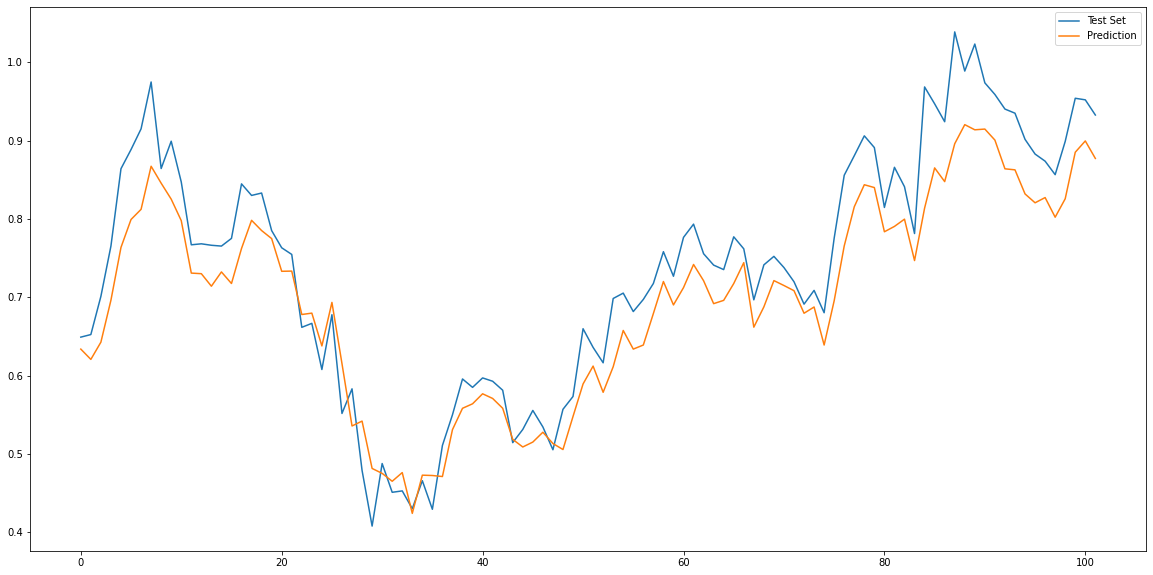

In [149]:
plt.figure(figsize=(20,10))
plt.plot(y_test)
plt.plot(y_pred)
plt.plot
plt.legend(['Test Set','Prediction'])

In [11]:
pred = pd.DataFrame(y_pred,columns=['Pred'])
y = pd.DataFrame(y_test,columns=['Test'])

results = y.join(pred)
results['Test Diff'] = results['Test'] - results['Test'].shift()
results['Pred Diff'] = results['Pred'] - results['Pred'].shift()

results['Test Direction'] = results['Test Diff'].apply(lambda x: 'DOWN' if x < 0 else 'UP')
results['Pred Direction'] = results['Pred Diff'].apply(lambda x: 'DOWN' if x < 0 else 'UP')

results = results[1:]

print("Model Accuracy: ",basic_accuracy_derivation(results))


Model Accuracy:  0.871


In [158]:
# print("Model Accuracy: ",basic_accuracy_derivation(results))

# Predicting Independent Variables

scaler = MinMaxScaler(feature_range=(-1,1))

pred_ind_stock_vars = []
ind_vars = data.loc[:,data.columns != 'Close']
for i in ind_vars.columns:
    train = ind_vars[i]
    train_ss = train.values.reshape(-1,1)
    train_ss = scaler.fit_transform(train_ss)

    n_input = 1
    n_features = 1
    generator = TimeseriesGenerator(train_ss, train_ss, length=n_input, batch_size=5)

    K.clear_session()
    model = Sequential()
    model.add(LSTM(12, input_shape=(n_input,n_features)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stop = EarlyStopping(monitor='loss',patience=1,verbose=0)
    history = model.fit(generator,epochs=100,verbose=0,callbacks=[early_stop])


    batch = train_ss[-n_input:].reshape((1, n_input, n_features))
    # Actual prediction
    ind_var_pred_value = model.predict(batch)[0][0]
    # Inverse Transform 
    ind_var_pred_value = scaler.inverse_transform(ind_var_pred_value.reshape(-1,1))
    # Save "True to Size" Value for Overall Model
    pred_ind_stock_vars.append(ind_var_pred_value[0][0]) 

# Scale Values Similar to Original Training
pred_ind_stock_vars = np.array(pred_ind_stock_vars).reshape(-1,1)
pred_ind_stock_vars = ss.fit_transform(pred_ind_stock_vars)
for_overall_model = np.array(pred_ind_stock_vars).reshape(1,1,8)

price_pred = price_model.predict(for_overall_model)[0]
print(price_pred)
tomorrow_pred = 'UP' if results.iloc[-1]['Pred']< price_pred else 'DOWN'

print(f'The model predicts {ticker} price action to be {tomorrow_pred}')


Model Accuracy:  0.871
[0.79651856]
The model predicts SQ price action to be DOWN


In [12]:
results

,Test,Pred,Test Diff,Pred Diff,Test Direction,Pred Direction
1,0.607747,0.555041,0.025387,0.010221,UP,UP
2,0.623577,0.570604,0.015830,0.015563,UP,UP
3,0.641158,0.583700,0.017581,0.013096,UP,UP
4,0.706084,0.622125,0.064926,0.038424,UP,UP
5,0.722644,0.637659,0.016560,0.015534,UP,UP
...,...,...,...,...,...,...
88,0.815801,0.695074,-0.008243,0.008290,DOWN,UP
89,0.805661,0.698624,-0.010140,0.003549,DOWN,UP
90,0.778086,0.673851,-0.027575,-0.024773,DOWN,DOWN
91,0.792968,0.691348,0.014882,0.017497,UP,UP


### Second Version of Out of Sample Prediction
* working with ARIMA and VAR models in StatsModels

In [162]:
from statsmodels.tsa.arima.model import ARIMA

scaler = MinMaxScaler(feature_range=(0,1))

pred_ind_stock_vars = {}
for i in ind_vars.columns:
    train_ss = ind_vars[i].values.reshape(-1,1)
    train_ss = scaler.fit_transform(single_var)

    # fit model
    model = ARIMA(train_ss, order=(1, 1, 1))
    model_fit = model.fit()
    # make prediction of 3 sessions
    forecast = model_fit.predict(start=len(train_ss),end=len(train_ss)+2).reshape(-1,1)
#     forecast = scaler.inverse_transform(forecast)
    output = []
    for f in range(len(forecast)):
        output.append(forecast[f][0])
    
    pred_ind_stock_vars[i] = output
    
var_forecast = pd.DataFrame(pred_ind_stock_vars)

direction_preds = []
price_preds = []
last_pred_value = price_model.predict(X_test)[-1][0]
price_pred = None
for x in range(0,len(var_forecast)):
    if x == 0:
        single_day_values = var_forecast.iloc[x].values.reshape(1,1,8)
        price_pred = price_model(single_day_values)
        last_pred_value = price_model.predict(X_test)[-1][0]
        
        
        tomorrow_pred = 'UP' if last_pred_value < price_pred else 'DOWN'
        
        price_inverse = target_ss.inverse_transform(price_pred[0].numpy()[0].reshape(-1,1))[0][0]
        price_preds.append(price_inverse)
        direction_preds.append(tomorrow_pred)
    else:
        single_day_values = var_forecast.iloc[x].values.reshape(1,1,8)
        price_pred = price_model(single_day_values)
        
        # DB interation
        # TODO
        # Should be the last value predicted by the model
        last_pred_value = price_pred[0].numpy()[0]
        tomorrow_pred = 'UP' if last_pred_value < price_pred else 'DOWN'
        price_inverse = target_ss.inverse_transform(price_pred[0].numpy()[0].reshape(-1,1))[0][0]
        price_preds.append(price_inverse)
        direction_preds.append(tomorrow_pred)


In [172]:
direction_preds

['UP', 'DOWN', 'DOWN']

In [173]:
price_preds

[278.68024, 278.69104, 278.69217]

In [49]:
# VAR example
from statsmodels.tsa.vector_ar.var_model import VAR
from random import random
# contrived dataset with dependency
test = ind_vars.values
model = VAR(test)
model_fit = model.fit()
# make prediction
yhat = model_fit.forecast(model_fit.y, steps=3)


array([[226.88425794, 220.30856146, 223.77113879,  78.90915026,
        196.76269282, 209.69165871,  84.92935168,  89.12586469],
       [227.13233126, 220.42048891, 223.87891416,  67.56891243,
        198.38179301, 211.31903098,  78.07304604,  85.31968229],
       [227.40478339, 220.61890856, 224.10824449,  61.86322389,
        199.90361734, 212.85733912,  72.69738034,  79.92294917]])

In [50]:
for i in yhat:
    print(i)

[226.88425794 220.30856146 223.77113879  78.90915026 196.76269282
 209.69165871  84.92935168  89.12586469]
[227.13233126 220.42048891 223.87891416  67.56891243 198.38179301
 211.31903098  78.07304604  85.31968229]
[227.40478339 220.61890856 224.10824449  61.86322389 199.90361734
 212.85733912  72.69738034  79.92294917]


In [174]:
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random
# contrived dataset with dependency
test = ind_vars.values
model = VARMAX(test,order=(1,1))
model_fit = model.fit(disp=False)
# make prediction
yhat_VARMAX = model_fit.forecast(model_fit.y, steps=3)
yhat_VARMAX

/Users/kinkadedarling/anaconda3/envs/fds/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/Users/kinkadedarling/anaconda3/envs/fds/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


KeyboardInterrupt: 

In [ ]:
# # pred and Y are already dataframe objects

# X_test_DF = pd.DataFrame(X_test.transpose().reshape(25,-1))
# X_test_with_PRED = pred.join(X_test_DF)

# inverse_trans_pred = pd.DataFrame(ss.inverse_transform(X_test_with_PRED),
#                                   columns=['Close','High','Low','Open',
#                                            'Volume', 'RSI', 'Lower Kelt','Upper Kelt',
#                                            'Fast Stoch','Slow Stoch'])

# inverse_trans_pred = inverse_trans_pred['Close']
# inverse_trans_pred = inverse_trans_pred.pct_change()
# percent_change = round(inverse_trans_pred.iloc[-1]*100,4)
# percent_change

In [ ]:
# path = 'production_modeling/current_production_'+ticker+'_price_model.h5'
# price_model.save(path)

### NOTES

In [ ]:
pred = pd.DataFrame(y_pred,columns=['Pred'])
y = pd.DataFrame(y_test,columns=['Test'])

results = y.join(pred)
results['Test Diff'] = results['Test'] - results['Test'].shift()
results['Pred Diff'] = results['Pred'] - results['Pred'].shift()

results['Test Direction'] = results['Test Diff'].apply(lambda x: 'DOWN' if x < 0 else 'UP')
results['Pred Direction'] = results['Pred Diff'].apply(lambda x: 'DOWN' if x < 0 else 'UP')

results['dates'] = test_index
# Sunday is 6
# Monday is 0 
# etc
results['weekday'] = test_index.day_name()
results = results[1:]
# results.to_csv('current_SQ_model_results_5_28_2021.csv')

X_test_DF = pd.DataFrame(X_test.transpose().reshape(25,-1))
X_test_with_PRED = pred.join(X_test_DF)

inverse_trans_pred = pd.DataFrame(ss.inverse_transform(X_test_with_PRED),
                                  columns=['Close','High','Low','Open',
                                           'Volume', 'RSI', 'Lower Kelt','Upper Kelt',
                                           'Fast Stoch','Slow Stoch'])

inverse_trans_pred = inverse_trans_pred['Close']
inverse_trans_pred = inverse_trans_pred.pct_change()
percent_change = round(inverse_trans_pred.iloc[-1]*100,4)
direction = results.iloc[-1]['Pred Direction']
print(basic_accuracy_derivation(results))
print(f'SQ could move {direction} by {percent_change}%')

In [ ]:
data = pdr.DataReader(['SQ','PYPL'],'yahoo','2015-01-01','2021-06-21')['Adj Close']
data.dropna(inplace=True)
rolling_corr = data['SQ'].rolling(255).corr(data['PYPL'])

In [ ]:
rolling_corr.plot(title='Rolling Corr (255 days) of PYPL and SQ')